In [1]:
%matplotlib inline
import numpy as np

from scipy.stats import linregress
from scipy.stats import gmean, pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import rubisco_data

import matplotlib.colors
import seaborn as sns
import pandas as pd

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)

In [3]:
# Categories used to color enzymes by the physiology of their host organisms. 

titles = {'S': '$S_{C/O}$', 'vC': '$k_{cat,C}$', 'KC':
          '$K_C$', 'vO': '$k_{cat,O}$', 'KO': '$K_O$',
          'KRuBP': '$K_{RuBP}$'}
units = {'S': 'unitless', 'vC': '$s^{-1}$', 'KC':
         '$\mu M$', 'vO': '$s^{-1}$', 'KO': '$\mu M$',
         'KRuBP': '$\mu M$'}
group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'C3-C4 plants',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'CAM plants': 'CAM plants',
                 'Green algae': 'Green algae',
                 'Red algae': 'Red algae',
                 'Alphaproteobacteria': 'Proteobacterial Form I',
                 'Betaproteobacteria': 'Proteobacterial Form I',
                 'Gammaproteobacteria': 'Proteobacterial Form I',
                 'Diatoms': 'Other algae',
                 'Chromophyte algae': 'Other algae',
                 'Rhodophyte algae': 'Other algae',
                 'Haptophyte algae': 'Other algae',
                 'Macroalgae': 'Other algae',
                 'Carnivorous plants': 'Other plants',
                 'Basal angiosperm': 'Other plants',
                 'Gymnosperm': 'Other plants',
                }
marker_mapping = {
    'C3 plants': 'o',
    'C3-C4 plants': 'o',
    'C4 plants': 'o',
    'CAM plants': 'o',
    'Other plants': 'o',
    'Cyanobacteria': 'd',
    'Proteobacterial Form I': 'd',
    'Green algae': 'p',
    'Red algae': 'p',
    'Other algae': 'p',
}

color_mapping = {
    'C3 plants': 'dusty green',
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'CAM plants': 'navy blue',
    'Other plants': 'dark blue green',
    'Cyanobacteria': 'dark blue green',
    'Proteobacterial Form I': 'dusty rose',
    'Green algae': 'dusty teal',
    'Red algae': 'dusty red',
    'Other algae': 'dark blue green',
}
fancy_labels = {
    'C3-C4 plants': '$C_3$-$C_4$ plants',
    'C4 plants': '$C_4$ plants',
    'C3 plants': '$C_3$ plants',
}
label2color = dict((fancy_labels.get(k, k), sns.xkcd_rgb[color_mapping.get(k)])
                   for k in color_mapping.keys())

F1_data = merged_kin_df[merged_kin_df.isoform == '1']
F2_data = merged_kin_df[merged_kin_df.isoform == '2']
grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping)

# Order of plotting sets order of legend.
plotting_order = ['C3 plants', 'C3-C4 plants', 'C4 plants', 'CAM plants', 'Other plants',
                  'Green algae', 'Red algae', 'Other algae',
                  'Cyanobacteria', 'Proteobacterial Form I', ]

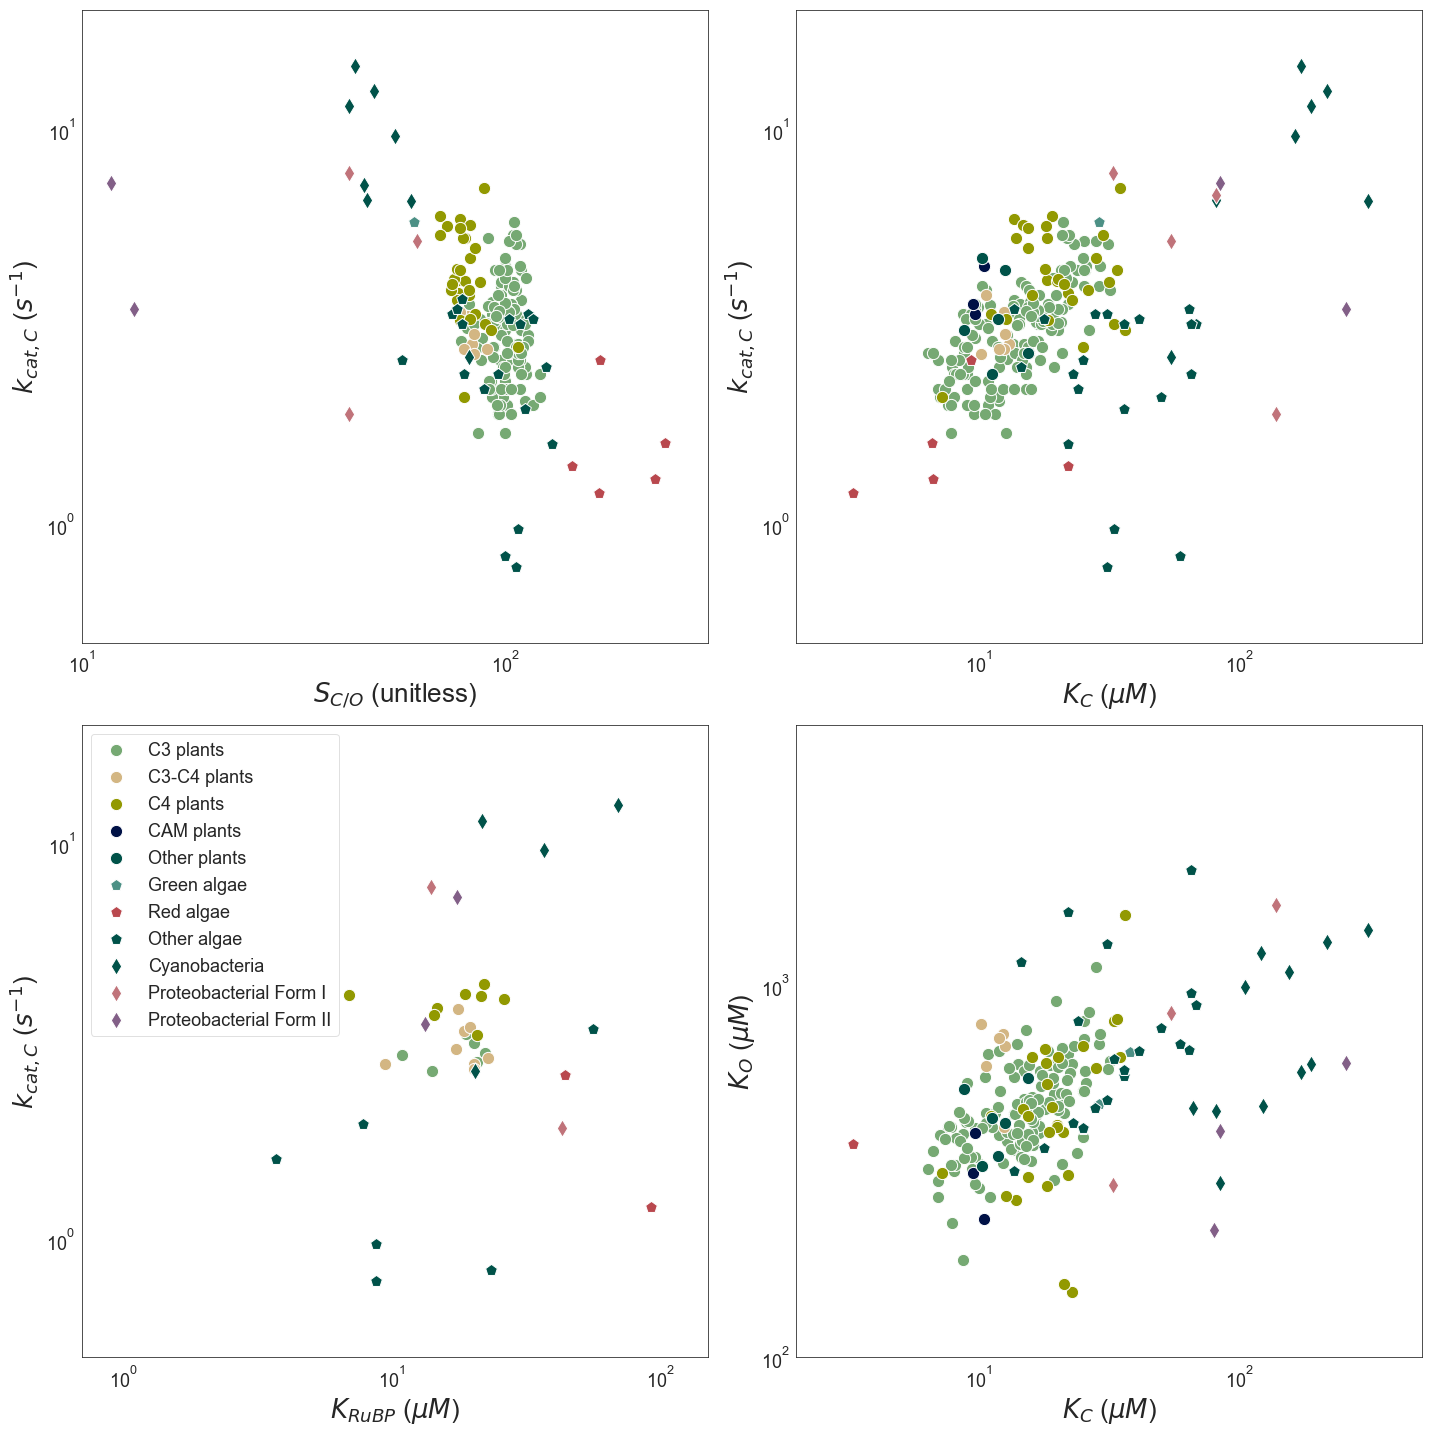

In [4]:
figure = plt.figure(figsize=(20,20))

sns.set_style('white')

def make_subplot(xvar, yvar):
    plt.xscale('log')
    plt.yscale('log')

    for i, group in enumerate(plotting_order):
        gdf = grouped_taxa.get_group(group)

        cname = color_mapping.get(group, 'dark grey')
        c = sns.xkcd_rgb[cname]
        marker = marker_mapping.get(group, 'o')
        
        mask = gdf[xvar].notnull() & gdf[yvar].notnull()

        plt.scatter(gdf[xvar], gdf[yvar],  c=[c], s=150,
                    marker=marker, label=group, edgecolors='w')
        
    cname = 'dusty purple'
    c = sns.xkcd_rgb[cname]
    plt.scatter(F2_data[xvar], F2_data[yvar],  c=[c], s=150, marker='d',
                label='Proteobacterial Form II', edgecolors='w')
    
    xlabel = '%s (%s)' % (titles[xvar], units[xvar])
    ylabel = '%s (%s)' % (titles[yvar], units[yvar])
    
    plt.xlabel(xlabel, fontsize=26)
    plt.ylabel(ylabel, fontsize=26)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

# kcat,C vs SC/O
plt.subplot('221')

make_subplot('S', 'vC')
plt.xlim(10, 300)
plt.ylim(5e-1, 20)

# kcat,C vs KC
plt.subplot('222')

make_subplot('KC', 'vC')

plt.ylim(5e-1, 20)
plt.xlim(2, 5e2)

# kcat,C vs KRuBP
plt.subplot('223')

make_subplot('KRuBP', 'vC')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=18, loc=2, frameon=True, framealpha=0.6)
plt.ylim(5e-1, 20)
plt.xlim(0.7, 1.5e2)

# KO vs KC
plt.subplot('224')

make_subplot('KC', 'KO')

plt.ylim(1e2, 5e3)
plt.xlim(2, 5e2)
plt.tight_layout()

plt.savefig('figS6/figS6_pairwise_corrs.png', dpi=200)
plt.show()